In [24]:
pip install pandas numpy openpyxl

Note: you may need to restart the kernel to use updated packages.


In [25]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import io

# --- Helper: Simulate the data.xlsx file for a runnable example ---
# In your project, you will replace this block with:
df_raw = pd.read_excel("data.xlsx")



# df_raw = pd.read_csv(io.StringIO(csv_data))

# ==============================================================================
# PHASE 1: DATA INGESTION AND PRE-PROCESSING
# ==============================================================================
print("--- Phase 1: Starting Data Pre-processing ---")

# Step 1.1: Load and Clean the Data
df = df_raw.copy()

# Convert data types
df['Issue Date'] = pd.to_datetime(df['Issue Date'])
df['Maturity'] = pd.to_datetime(df['Maturity'])
for col in ['Bid Price', 'Ask Price', 'Cpn']:
    df[col] = pd.to_numeric(df[col])

# Filter for consistent credit risk and currency
df = df[df['Currency'] == 'USD'].copy()
# Note: The issuer filter is already implicitly handled by the sample data.

# Step 1.2: Establish a Valuation Date
# All calculations are relative to this date.
# For reproducibility, we'll fix this date. In a real-world scenario,
# this would often be set to the current business day.
VALUATION_DATE = datetime(2025, 2, 28)
print(f"Valuation Date set to: {VALUATION_DATE.strftime('%Y-%m-%d')}")

# Filter out bonds that have already matured as of the valuation date
df = df[df['Maturity'] > VALUATION_DATE].copy()

# Step 1.3: Prepare Bond-Specific Data
df['Market_Price'] = (df['Bid Price'] + df['Ask Price']) / 2
df['Maturity_in_Years'] = (df['Maturity'] - VALUATION_DATE).dt.days / 365.25

# Step 1.4: Generate Cash Flow Schedules for Each Bond
def generate_cashflows(bond_row, valuation_date):
    """
    Generates a list of future cash flows for a single bond.
    Assumes semi-annual coupon payments.

    Args:
        bond_row (pd.Series): A row from the DataFrame representing one bond.
        valuation_date (datetime): The date from which to value the cash flows.

    Returns:
        list: A list of tuples, where each tuple is (time_to_payment_in_years, amount).
    """
    cashflows = []
    coupon_rate = bond_row['Cpn']
    maturity_date = bond_row['Maturity']
    
    # Final payment: Principal (100) + final coupon
    final_coupon = coupon_rate / 2.0
    cashflows.append((maturity_date, 100.0 + final_coupon))
    
    # Generate previous coupon payments
    # Start from the maturity and step back 6 months at a time
    current_payment_date = maturity_date
    while True:
        current_payment_date -= relativedelta(months=6)
        if current_payment_date <= valuation_date:
            break
        cashflows.append((current_payment_date, final_coupon))
        
    # Convert dates to time in years from valuation_date and sort
    cashflows_in_years = []
    for payment_date, amount in cashflows:
        time_to_payment = (payment_date - valuation_date).days / 365.25
        cashflows_in_years.append((time_to_payment, amount))
        
    # Return sorted by time
    return sorted(cashflows_in_years, key=lambda x: x[0])

# Apply the function to each row of the DataFrame
df['Cashflows'] = df.apply(generate_cashflows, axis=1, valuation_date=VALUATION_DATE)

print("\nData pre-processing complete. DataFrame head:")
print(df[['Maturity', 'Market_Price', 'Maturity_in_Years', 'Cashflows']].head())
print("\n--- Phase 1 Complete ---")

# ==============================================================================
# PHASE 2: MODEL DEFINITION AND OBJECTIVE FUNCTION
# ==============================================================================
print("\n--- Phase 2: Defining Model and Objective Functions ---")

# Step 2.1: Implement the Nelson-Siegel Formula
def nelson_siegel_rate(t, beta0, beta1, beta2, tau):
    """
    Calculates the continuously compounded spot rate for a given time 't'
    using the Nelson-Siegel model.

    Args:
        t (float): Time in years.
        beta0, beta1, beta2, tau: Nelson-Siegel model parameters.

    Returns:
        float: The spot rate r(t).
    """
    # Handle the edge case of t=0 to avoid division by zero
    if t < 1e-6:
        return beta0 + beta1
        
    term1 = beta0
    term2 = beta1 * (1 - np.exp(-t / tau)) / (t / tau)
    term3 = beta2 * ((1 - np.exp(-t / tau)) / (t / tau) - np.exp(-t / tau))
    
    return term1 + term2 + term3

# Step 2.2: Create the Bond Pricing Function
def calculate_model_price(bond_cashflows, beta0, beta1, beta2, tau):
    """
    Calculates the theoretical price of a bond given its cash flows and
    the Nelson-Siegel parameters.

    Args:
        bond_cashflows (list): List of (time, amount) tuples for a bond.
        beta0, beta1, beta2, tau: Nelson-Siegel model parameters.

    Returns:
        float: The theoretical clean price of the bond.
    """
    total_present_value = 0.0
    for t, cf_amount in bond_cashflows:
        # Get the appropriate discount rate for this cash flow's maturity
        rate = nelson_siegel_rate(t, beta0, beta1, beta2, tau)
        # Discount the cash flow and add to total
        total_present_value += cf_amount * np.exp(-rate * t)
        
    return total_present_value

# Step 2.3: Define the Global Error (Objective) Function
def sum_of_squared_errors(params, df_bonds):
    """
    The objective function to be minimized. It calculates the sum of
    squared differences between model prices and market prices for all bonds.

    Args:
        params (list or array): A list containing [beta0, beta1, beta2, tau].
        df_bonds (pd.DataFrame): The DataFrame containing bond data, including
                                 'Market_Price' and 'Cashflows'.

    Returns:
        float: The total squared error.
    """
    beta0, beta1, beta2, tau = params
    total_squared_error = 0.0
    
    for index, row in df_bonds.iterrows():
        market_price = row['Market_Price']
        cashflows = row['Cashflows']
        
        model_price = calculate_model_price(cashflows, beta0, beta1, beta2, tau)
        
        # We can add a weighting here, e.g., by duration, but for now
        # a simple squared error is standard.
        error = (model_price - market_price) ** 2
        total_squared_error += error
        
    return total_squared_error

print("Nelson-Siegel model functions are defined and ready for optimization.")

# --- Test the objective function with a sample set of parameters ---
# This confirms our functions are working before we move to Phase 3.
initial_guess_params = [0.06, -0.03, 0.03, 25.5] # [beta0, beta1, beta2, tau]
initial_error = sum_of_squared_errors(initial_guess_params, df)
print(f"\nTest run: Initial error with guess parameters {initial_guess_params} is: {initial_error:.4f}")
print("--- Phase 2 Complete ---")

# The output of this script ('df' and 'sum_of_squared_errors') is now ready
# to be used in Phase 3 for the actual optimization.

--- Phase 1: Starting Data Pre-processing ---
Valuation Date set to: 2025-02-28

Data pre-processing complete. DataFrame head:
    Maturity  Market_Price  Maturity_in_Years  \
3 2025-03-15     99.886719           0.041068   
4 2025-03-31     99.662109           0.084873   
5 2025-03-31     99.964844           0.084873   
6 2025-03-31     99.853516           0.084873   
7 2025-04-15     99.791016           0.125941   

                           Cashflows  
3   [(0.04106776180698152, 100.875)]  
4    [(0.08487337440109514, 100.25)]  
5  [(0.08487337440109514, 101.9375)]  
6  [(0.08487337440109514, 101.3125)]  
7  [(0.12594113620807665, 101.3125)]  

--- Phase 1 Complete ---

--- Phase 2: Defining Model and Objective Functions ---
Nelson-Siegel model functions are defined and ready for optimization.

Test run: Initial error with guess parameters [0.06, -0.03, 0.03, 25.5] is: 2754.8240
--- Phase 2 Complete ---


In [26]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.



--- Phase 3: Starting Optimization to Fit Parameters ---
Initial guess for [β0, β1, β2, τ]: [0.03, -0.01, 0.01, 1.5]
Error before optimization: 52500.6224


C:\Users\kzhan\AppData\Local\Temp\ipykernel_15008\3151322896.py:41: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  optimization_result = minimize(



Optimization successful!
Final minimized error: 134.9020
Optimal Parameters [β0, β1, β2, τ]:
  β0 = 0.049755
  β1 = 0.004015
  β2 = -0.028668
  τ  = 2.071634
--- Phase 3 Complete ---

--- Phase 4: Generating Final Curve Function and Plot ---
Yield at 2 years: 4.4861%
Yield at 5 years: 4.3021%
Yield at 10 years: 4.4919%

Generating plot...

Comparison of Market vs. Model Prices:
      Maturity  Market_Price  Model_Price  Pricing_Error
3   2025-03-15     99.886719   100.653813       0.767095
4   2025-03-31     99.662109    99.799062       0.136952
5   2025-03-31     99.964844   101.478971       1.514127
6   2025-03-31     99.853516   100.856782       1.003267
7   2025-04-15     99.791016   100.640862       0.849847
..         ...           ...          ...            ...
342 2054-02-15     93.398438    92.024885      -1.373552
343 2054-05-15     99.460938    99.087092      -0.373846
344 2054-08-15     93.554688    91.934667      -1.620021
345 2054-11-15     97.640625    97.004954      -

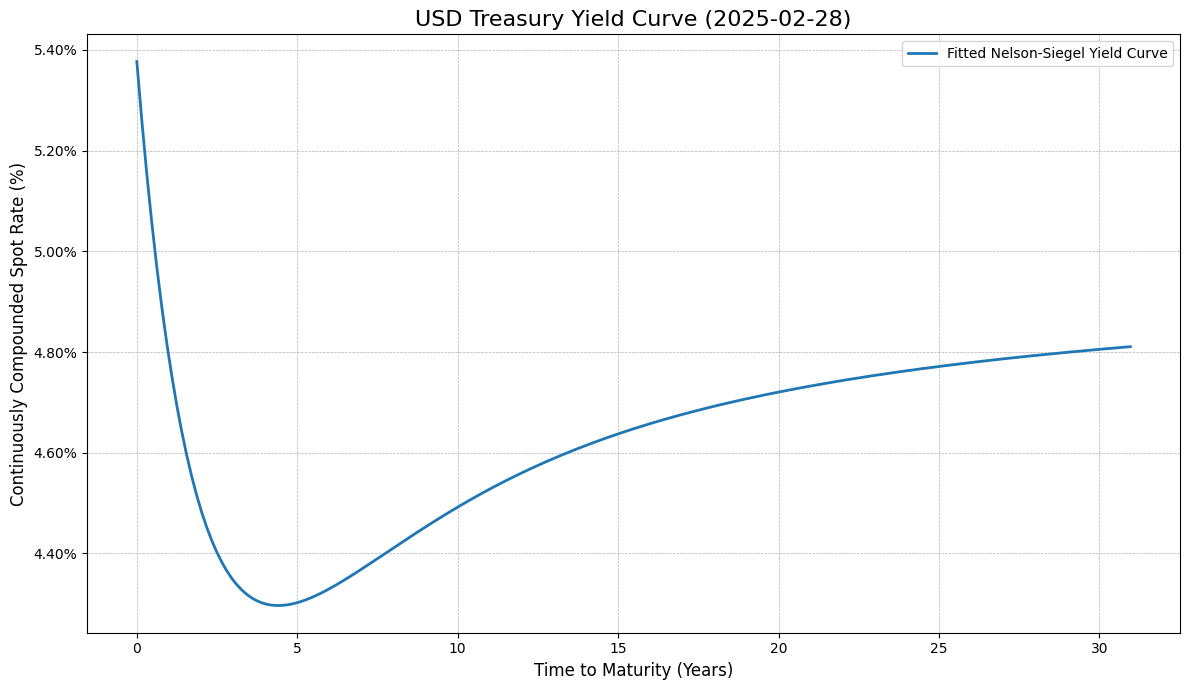

--- Phase 4 Complete ---


In [ ]:
# Assuming the code from Phase 1 and 2 has been run and the following
# variables are in memory:
# - df: The processed DataFrame with bond data and cashflows.
# - sum_of_squared_errors: The objective function to minimize.
# - nelson_siegel_rate: The function to calculate rates.
# - VALUATION_DATE: The date for our analysis.

# We will need these additional libraries for this part.
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# ==============================================================================
# PHASE 3: OPTIMIZATION AND PARAMETER FITTING
# ==============================================================================
print("\n--- Phase 3: Starting Optimization to Fit Parameters ---")

# Step 3.1: Set Up the Optimization
# The optimizer needs a starting point. Your guess is a great starting point.
# initial_guess_params = [0.06, -0.03, 0.03, 25.5]
# Let's use a more standard initial guess, which often works well.
initial_guess_params = [0.03, -0.01, 0.01, 1.5]

print(f"Initial guess for [β0, β1, β2, τ]: {initial_guess_params}")
initial_error = sum_of_squared_errors(initial_guess_params, df)
print(f"Error before optimization: {initial_error:.4f}")

# It's good practice to set bounds to guide the optimizer and prevent
# it from trying nonsensical parameter values.
# (beta0, beta1, beta2, tau)
bounds = [
    (0, 0.2),      # beta0 (long-term rate) should be between 0% and 20%
    (-0.2, 0.2),   # beta1 (slope) can be negative or positive
    (-0.2, 0.2),   # beta2 (curvature) can be negative or positive
    (0.1, 30.0)    # tau (scale) must be positive and is typically in this range
]

# Step 3.2: Run the Optimizer
# We use `scipy.optimize.minimize`.
# 'L-BFGS-B' is a good method that respects bounds.
optimization_result = minimize(
    fun=sum_of_squared_errors,  # The function to minimize
    x0=initial_guess_params,    # The starting guess
    args=(df,),                 # Extra arguments to pass to our function (the DataFrame)
    method='L-BFGS-B',
    bounds=bounds,
    options={'disp': True}      # Display convergence messages
)

# Step 3.3: Extract the Optimal Parameters
if optimization_result.success:
    optimal_params = optimization_result.x
    final_error = optimization_result.fun
    print("\nOptimization successful!")
    print(f"Final minimized error: {final_error:.4f}")
    print(f"Optimal Parameters [β0, β1, β2, τ]:")
    print(f"  β0 = {optimal_params[0]:.6f}")
    print(f"  β1 = {optimal_params[1]:.6f}")
    print(f"  β2 = {optimal_params[2]:.6f}")
    print(f"  τ  = {optimal_params[3]:.6f}")
else:
    print("\nOptimization failed to converge.")
    print(optimization_result.message)
    # Handle the failure case, maybe by exiting or using the initial guess
    optimal_params = initial_guess_params

print("--- Phase 3 Complete ---")



In [29]:
pip install plotly

   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.8 MB 2.3 MB/s eta 0:00:04
   --- ------------------------------------ 0.8/9.8 MB 2.2 MB/s eta 0:00:05
   --- ------------------------------------ 0.8/9.8 MB 2.2 MB/s eta 0:00:05
   ---- ----------------------------------- 1.0/9.8 MB 1.4 MB/s eta 0:00:07
   ------ --------------------------------- 1.6/9.8 MB 1.5 MB/s eta 0:00:06
   ------- -------------------------------- 1.8/9.8 MB 1.4 MB/s eta 0:00:06
   --------- ------------------------------ 2.4/9.8 MB 1.5 MB/s eta 0:00:05
   ---------- ----------------------------- 2.6/9.8 MB 1.6 MB/s eta 0:00:05
   ------------ --------------------------- 3.1/9.8 MB 1.6 MB/s eta 0:00:05
   -------------- ------------------------- 3.7/9.8 MB 1.7 MB/s eta 0:00:04
   ---------------- ----------------------- 3.9/9.8 MB 1.7 MB/s eta 0:00:04
   ----------------- ---------------------- 4.2/9.8 MB 1.7 MB/s eta 0:00:04
   ----------------

In [30]:
from scipy.optimize import brentq

# ==============================================================================
# PHASE 4 (REVISED): YIELD CURVE VISUALIZATION WITH PLOTLY
# ==============================================================================
import plotly.graph_objects as go
import plotly.io as pio

# Set default plotly theme
pio.templates.default = "plotly_white"

print("\n--- Phase 4 (Plotly): Generating Final Curve Function and Interactive Plot ---")

# Step 4.1: Develop the Final Yield Curve Function (same as before)
def get_yield_curve_rate(t):
    beta0_opt, beta1_opt, beta2_opt, tau_opt = optimal_params
    return nelson_siegel_rate(t, beta0_opt, beta1_opt, beta2_opt, tau_opt)


# --- New Step: Calculate YTM for each bond for the scatter plot ---
def calculate_ytm(bond_row):
    """
    Calculates the continuously compounded Yield-to-Maturity (YTM) for a single bond.
    This requires finding the single discount rate 'y' that makes the bond's
    theoretical price equal to its market price.
    """
    market_price = bond_row['Market_Price']
    cashflows = bond_row['Cashflows']
    
    # Define an error function for the root finder
    def price_error(ytm):
        pv = sum([cf * np.exp(-ytm * t) for t, cf in cashflows])
        return pv - market_price

    # Use a robust root-finding algorithm (Brent's method) to find the YTM
    try:
        # Search for a YTM between -0.05 ( -5%) and 0.25 (25%)
        return brentq(price_error, -0.05, 0.25)
    except ValueError:
        # If the root isn't in the bracket, return NaN
        return np.nan

# Apply the YTM calculation to each bond in the DataFrame
df['YTM'] = df.apply(calculate_ytm, axis=1)

print("\nCalculated YTM for each bond:")
print(df[['Maturity_in_Years', 'Market_Price', 'YTM']])


# Step 4.2: Prepare Data for Plotting the Curve
max_maturity = df['Maturity_in_Years'].max()
plot_t = np.linspace(0, max_maturity + 1, 200) # x-axis for smooth curve
plot_y = [get_yield_curve_rate(t) * 100 for t in plot_t] # y-axis for smooth curve


# Step 4.3: Create the Interactive Visualization with Plotly
print("\nGenerating interactive plot...")
fig = go.Figure()

# Add the smooth Nelson-Siegel curve trace
fig.add_trace(go.Scatter(
    x=plot_t,
    y=plot_y,
    mode='lines',
    line=dict(width=3),
    name='Fitted Nelson-Siegel Curve'
))

# Add the scatter plot of individual bond YTMs
fig.add_trace(go.Scatter(
    x=df['Maturity_in_Years'],
    y=df['YTM'] * 100,
    mode='markers',
    name='Individual Bond YTMs',
    marker=dict(size=8, opacity=0.7),
    # Custom hover text to show details for each bond
    hovertemplate=(
        "<b>Maturity:</b> %{x:.2f} years<br>"
        "<b>YTM:</b> %{y:.3f}%<br>"
        "<b>Coupon:</b> %{customdata[0]:.3f}%<br>"
        "<b>Price:</b> %{customdata[1]:.4f}"
        "<extra></extra>" # Hides the trace name from the tooltip
    ),
    customdata=df[['Cpn', 'Market_Price']]
))

# Customize the layout of the plot
fig.update_layout(
    title=dict(
        text=f"<b>USD Treasury Yield Curve ({VALUATION_DATE.strftime('%Y-%m-%d')})</b>",
        x=0.5,
        font=dict(size=20)
    ),
    xaxis_title="Time to Maturity (Years)",
    yaxis_title="Yield (%)",
    xaxis=dict(zeroline=False),
    yaxis=dict(
        zeroline=False,
        ticksuffix="%" # Adds a '%' sign to the y-axis ticks
    ),
    legend=dict(
        yanchor="top", y=0.98,
        xanchor="left", x=0.8
    ),
    height=600
)

# Show the figure
fig.show()

print("--- Phase 4 (Plotly) Complete ---")


--- Phase 4 (Plotly): Generating Final Curve Function and Interactive Plot ---

Calculated YTM for each bond:
     Maturity_in_Years  Market_Price       YTM
3             0.041068     99.886719  0.239735
4             0.084873     99.662109  0.069297
5             0.084873     99.964844  0.230241
6             0.084873     99.853516  0.170908
7             0.125941     99.791016  0.120149
..                 ...           ...       ...
342          28.963723     93.398438  0.046247
343          29.207392     99.460938  0.046891
344          29.459274     93.554688  0.046115
345          29.711157     97.640625  0.046754
346          29.963039     99.781250  0.045962

[344 rows x 3 columns]

Generating interactive plot...


--- Phase 4 (Plotly) Complete ---


In [ ]:

print("\n--- Phase 4: Generating Final Curve Function and Plot ---")

# Step 4.1: Develop the Final Yield Curve Function
# This function 'closes over' the optimal parameters, making it easy to use.
def get_yield_curve_rate(t):
    """
    Calculates the spot rate for a given time 't' using the
    globally stored optimal Nelson-Siegel parameters.

    Args:
        t (float): Time in years.

    Returns:
        float: The continuously compounded spot rate.
    """
    beta0_opt, beta1_opt, beta2_opt, tau_opt = optimal_params
    return nelson_siegel_rate(t, beta0_opt, beta1_opt, beta2_opt, tau_opt)

# Test the function for a few maturities
print(f"Yield at 2 years: {get_yield_curve_rate(2.0) * 100:.4f}%")
print(f"Yield at 5 years: {get_yield_curve_rate(5.0) * 100:.4f}%")
print(f"Yield at 10 years: {get_yield_curve_rate(10.0) * 100:.4f}%")


# Step 4.2: Prepare Data for Plotting
# Create a smooth range of time points for our x-axis.
max_maturity = df['Maturity_in_Years'].max()
plot_t = np.linspace(0, max_maturity + 1, 200)

# Calculate the yield for each point using our final function.
# Multiply by 100 to show as a percentage.
plot_y = [get_yield_curve_rate(t) * 100 for t in plot_t]

# Step 4.3: Create the Visualization
print("\nGenerating plot...")
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the smooth curve
ax.plot(plot_t, plot_y, lw=2, label='Fitted Nelson-Siegel Yield Curve')

# --- Optional but recommended: Check model prices vs market prices ---
# This is a great sanity check to see how well the model performed.
model_prices = []
market_prices = df['Market_Price'].tolist()
for index, row in df.iterrows():
    price = calculate_model_price(row['Cashflows'], *optimal_params)
    model_prices.append(price)

price_comparison = pd.DataFrame({
    'Maturity': df['Maturity'],
    'Market_Price': market_prices,
    'Model_Price': model_prices
})
price_comparison['Pricing_Error'] = price_comparison['Model_Price'] - price_comparison['Market_Price']
print("\nComparison of Market vs. Model Prices:")
print(price_comparison)


# Finalize the plot
ax.set_title(f"USD Treasury Yield Curve ({VALUATION_DATE.strftime('%Y-%m-%d')})", fontsize=16)
ax.set_xlabel("Time to Maturity (Years)", fontsize=12)
ax.set_ylabel("Continuously Compounded Spot Rate (%)", fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Format y-axis to show percentage sign
ax.yaxis.set_major_formatter(mticker.PercentFormatter())
ax.legend()
plt.tight_layout()
plt.show()

print("--- Phase 4 Complete ---")